In [1]:
import numpy 
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from keras import optimizers

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
    
        
        a = dataset[i:(i+look_back), 0]
        
        dataX.append(a)
        
        dataY.append(dataset[i + look_back, 0])
        
        
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
df = pd.read_csv('Production.csv',header=0)
df = df[['Bhp', 'Gas']]
dataset = df.values
#dataset = dataset[0:3000]


In [26]:
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
look_back = 1
n_features = 2
n_obs = look_back*(n_features-1)+(n_features-1)
reframed = series_to_supervised(dataset, look_back, 1)
print(reframed)
values = reframed.values
# split into train and test sets
train_size = int(len(values) * 0.8)
#train_size = 2000
test_size = len(values) - train_size

train, test = values[0:train_size,:], values[train_size:len(values),:]

     var1(t-1)  var2(t-1)   var1(t)   var2(t)
1     0.001129   0.000000  0.150780  0.452665
2     0.150780   0.452665  1.000000  0.917793
3     1.000000   0.917793  0.897040  1.000000
4     0.897040   1.000000  0.819222  0.945986
5     0.819222   0.945986  0.771333  0.018549
..         ...        ...       ...       ...
268   0.230666   0.387021  0.223826  0.398116
269   0.223826   0.398116  0.210749  0.376872
270   0.210749   0.376872  0.218973  0.395372
271   0.218973   0.395372  0.196849  0.384801
272   0.196849   0.384801  0.234968  0.368846

[272 rows x 4 columns]


In [27]:
# reshape into X=t and Y=t+1

trainX, trainY = train[:, :n_obs], train[:, -1]
testX, testY = test[:, :n_obs], test[:, -1]

In [28]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back+1, n_features-1))
testX = numpy.reshape(testX, (testX.shape[0], look_back+1, n_features-1))

In [29]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back+1, n_features-1))
testX = numpy.reshape(testX, (testX.shape[0], look_back+1, n_features-1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(8, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=16, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/200
14/14 - 3s - loss: 0.2614
Epoch 2/200
14/14 - 0s - loss: 0.2225
Epoch 3/200
14/14 - 0s - loss: 0.1828
Epoch 4/200
14/14 - 0s - loss: 0.1419
Epoch 5/200
14/14 - 0s - loss: 0.1024
Epoch 6/200
14/14 - 0s - loss: 0.0652
Epoch 7/200
14/14 - 0s - loss: 0.0359
Epoch 8/200
14/14 - 0s - loss: 0.0176
Epoch 9/200
14/14 - 0s - loss: 0.0113
Epoch 10/200
14/14 - 0s - loss: 0.0105
Epoch 11/200
14/14 - 0s - loss: 0.0106
Epoch 12/200
14/14 - 0s - loss: 0.0105
Epoch 13/200
14/14 - 0s - loss: 0.0105
Epoch 14/200
14/14 - 0s - loss: 0.0105
Epoch 15/200
14/14 - 0s - loss: 0.0105
Epoch 16/200
14/14 - 0s - loss: 0.0105
Epoch 17/200
14/14 - 0s - loss: 0.0105
Epoch 18/200
14/14 - 0s - loss: 0.0105
Epoch 19/200
14/14 - 0s - loss: 0.0105
Epoch 20/200
14/14 - 0s - loss: 0.0105
Epoch 21/200
14/14 - 0s - loss: 0.0105
Epoch 22/200
14/14 - 0s - loss: 0.0106
Epoch 23/200
14/14 - 0s - loss: 0.0105
Epoch 24/200
14/14 - 0s - loss: 0.0105
Epoch 25/200
14/14 - 0s - loss: 0.0105
Epoch 26/200
14/14 - 0s - loss: 0.

In [30]:
# invert predictions
trainX = trainX.reshape((trainX.shape[0], n_obs))

n_f = n_features - 1
# invert scaling for forecast
inv_ypred = numpy.concatenate((trainX[:,-n_f:],trainPredict), axis=1)

inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,n_f]
# invert scaling for actual
trainY = trainY.reshape((len(trainY), 1))
predY = numpy.concatenate((trainX[:,-n_f:],trainY), axis=1)
predY = scaler.inverse_transform(predY)
predY = predY[:,n_f]

ValueError: non-broadcastable output operand with shape (217,1) doesn't match the broadcast shape (217,2)

In [21]:
# invert predictions
trainX = trainX.reshape((trainX.shape[0], n_obs))

n_f = n_features - 1
# invert scaling for forecast
inv_ypred = numpy.concatenate((trainX[:,-n_f:],trainPredict), axis=1)

inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,n_f]
# invert scaling for actual
trainY = trainY.reshape((len(trainY), 1))
predY = numpy.concatenate((trainX[:,-n_f:],trainY), axis=1)
predY = scaler.inverse_transform(predY)
predY = predY[:,n_f]

In [22]:
# make a prediction

testX = testX.reshape((testX.shape[0], n_obs))

# invert scaling for forecast
inv_yhat = numpy.concatenate((testX[:,-n_f:],testPredict), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,n_f]
# invert scaling for actual
testY = testY.reshape((len(testY), 1))
invY = numpy.concatenate((testX[:,-n_f:],testY), axis=1)
invY = scaler.inverse_transform(invY)
invY = invY[:,n_f]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(invY, inv_yhat))
print('Test RMSE: %.8f' % rmse)

Test RMSE: 0.06749017


In [23]:
inv_ypred = inv_ypred.reshape((len(inv_ypred), 1))
predY = predY.reshape((len(predY), 1))
inv_yhat = inv_yhat.reshape((len(inv_yhat), 1))
invY = invY.reshape((len(invY), 1))
plotpredY = numpy.concatenate((inv_ypred, predY), axis=1)
plotactY = numpy.concatenate((inv_yhat, invY), axis=1)

trainPredictPlot = numpy.empty([len(dataset[:,0]),2])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(plotpredY)+look_back, :] = plotpredY

testPredictPlot = numpy.empty([len(dataset[:,0]),2])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(plotpredY)+look_back-1:len(dataset)-1, :] = plotactY

In [24]:
# invert scaling for forecast
inv_yhat = numpy.concatenate((testX[:,-n_f:],testPredict), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,n_f]
# invert scaling for actual
testY = testY.reshape((len(testY), 1))
invY = numpy.concatenate((testX[:,-n_f:],testY), axis=1)
invY = scaler.inverse_transform(invY)
invY = invY[:,n_f]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(invY, inv_yhat))
print('Test RMSE: %.8f' % rmse)

Test RMSE: 0.06749017


In [25]:
plotpredY = numpy.concatenate((inv_ypred, inv_yhat), axis=1)
plotactY =  numpy.concatenate((predY, invY), axis=0)
plt.figure(2)
plt.xlabel('Bottom Hole Pressure',fontsize=12)
plt.ylabel('Gas',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(inv_yhat,'r-',label='Predicted',linewidth=2)
plt.plot(invY,'b--',label='Actual')
plt.style.use('ggplot')
plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [15]:
trainPredictPlot = numpy.empty([len(dataset[:,0]),2])
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(plotpredY)+look_back, :] = plotpredY

testPredictPlot = numpy.empty([len(dataset[:,0]),2])
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(plotpredY)+look_back-1:len(dataset)-1, :] = plotactY

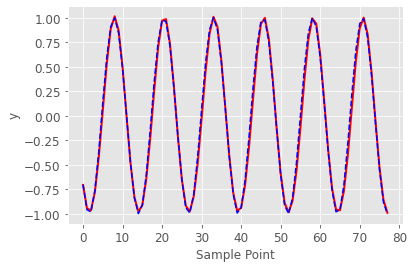

In [21]:
plotpredY = numpy.concatenate((inv_ypred, inv_yhat), axis=0)
plotactY =  numpy.concatenate((predY, invY), axis=0)
plt.figure(2)
plt.xlabel('Sample Point',fontsize=12)
plt.ylabel('y',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(inv_yhat,'r-',label='Predicted',linewidth=2)
plt.plot(invY,'b--',label='Actual')
plt.style.use('ggplot')
plt.show()

In [23]:
csv_path = "Production.csv"
df = pd.read_csv(csv_path)

In [24]:
df = df[['Bhp', 'Gas']]
# apply a min max scaler

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['Bhp'])

ValueError: Shape of passed values is (273, 2), indices imply (273, 1)

In [21]:

# convert to windowed data sets
ylist = list(df['Gas'])
n_future = 72
n_past = 3*72
total_period = 4*72
idx_end = len(ylist)
idx_start = idx_end - total_period
X_new = []
y_new = []
while idx_start > 0:
    x_line = ylist[idx_start:idx_start+n_past]
    y_line = ylist[idx_start+n_past:idx_start+total_period]
    X_new.append(x_line)
    y_new.append(y_line)
    idx_start = idx_start - 1

X_new = np.array(X_new)
y_new = np.array(y_new)

In [33]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, n_samples = 273, test_size=0.2, train_size = 0.8, random_state=42)

TypeError: Invalid parameters passed: {'n_samples': 273}

In [6]:
batch_size = 32
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1
X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

NameError: name 'X_train' is not defined

In [16]:
# reshape data into the right format for RNNs
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1
X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

ValueError: With n_samples=0, test_size=0.33 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [5]:
random.seed(42)
batch_size = 32
simple_model = Sequential([
    LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
    Dense(y_train.shape[1]),
])
simple_model.summary()

NameError: name 'n_timesteps' is not defined

In [ ]:
simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)
preds = simple_model.predict(X_test_rs)
print(r2_score(preds, y_test))

In [ ]:
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()